# The 1D Empirical Wavelet Transform

In [0]:
import numpy as np
from scipy.special import iv
import matplotlib.pyplot as plt

The goal of this notebook is to demonstrate the 1D empirical wavelet transform algorithmically. 

We begin by loading our signal into the variable f. Here, the signal we work on is $sig_2$, an example function described in [1]. 

Also, since the empirical wavelet transform is constructed in the Fourier domain, we begin by taking the fourier transform of our signal. 

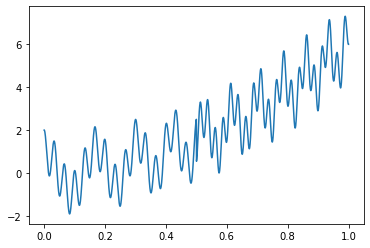

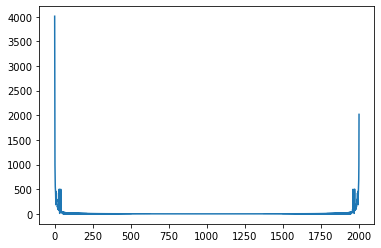

In [0]:
dt = .0005
t = np.arange(0,1+dt,dt)

f = 6*t**2
f += np.cos(10*np.pi*t + 10*np.pi*t**2)
f += (t > 0.5)*np.cos(80*np.pi*t-15*np.pi) + (t <= 0.5)*np.cos(60*np.pi*t)
plt.plot(t,f)
plt.show()

ff = np.fft.fft(f)

plt.plot(np.abs(ff))
plt.show()

At this point, we look to detect boundaries. We will be defining our boundaries using the scale-space method with Otsu's method as a thresholding technique to detect persistent minima, as was described by the authors in [2]. 

Before we can define a gaussian scale space function, we must first define a function that detects local minima. 

In [0]:
def localmin(f):
    w = len(f)
    minima = np.zeros(w)
    for i in range(0,w):
        minima[i] = 1
        right = 1
        while 1:
            if i - right >= 0:
                if f[i - right] < f[i]:
                    minima[i] = 0
                    break
                elif f[i - right] == f[i]:
                    right += 1
                else:
                    break
            else:
                break
        if minima[i] == 1:
            left = 1
            while 1:
                if i + left < w:
                    if f[i+left] < f[i]:
                        minima[i] = 0
                        break
                    elif f[i+left] == f[i]:
                        left += 1
                    else:
                        break
                else:
                    break
    i = 0
    while i < w:
        if minima[i] == 1:
            j = i
            flat_count = 1
            flag = 0
            while (j+1 < w) and (minima[j+1] == 1):
                minima[j] = 0
                flat_count += 1
                j += 1
                flag = 1
                print(minima)
            if flag == 1:
                minima[j - np.floor(flat_count/2).astype(int)] = 1
                minima[j] = 0
                i = j
        i += 1
                
    return minima

#Demonstrate use of local minima function
print(localmin(np.array([3, 4, 5, 2, 2, 2, 2, 2, 7, 7,5, 9, 2, 2, 2,7])))

[1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0.]
[1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0.]
[1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0.]
[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0.]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]


We then define the a function that takes as an input a signal and returns the minima detected at each scale of a discrete scale-space representation. 

Reminder that the scale-space representation of a signal $f$ is defined as the convolution between the signal and a smoothing kernel,
$$L(x,t) = \sum\limits_{n = -\infty}^\infty T(n,t)f(x-n,t).$$
$T(n,t)$ in this case is the discrete Gaussian kernel.

In [0]:
def GSS(f):
    t = 0.5
    n = 3
    num_iter = np.ceil(len(f)/n)
    #First, define scale-space kernel (discrete Gaussian kernel)
    ker = np.exp(-t)*iv(np.arange(-n,n+1),t)
    ker = ker/np.sum(ker)

    #Initialize place to store result of each layer GSS
    plane = np.zeros([len(f), num_iter.astype(int)+1])
    plane[:,0] = localmin(f)

    #Iterate through scalespace and store minima at each scale
    for i in range(1,num_iter.astype(int)+1):
        f = np.pad(f,n,'reflect')
        f = np.convolve(f,ker,'same')
        f = f[n:-n]
        plane[:,i] = localmin(f)
    return plane

Once we have our minima mapped in the fine-to-coarse representation of our signal $f$, we then track the minima detected in the original signal as they evolve in the scale-space representation. 

In [0]:
def lengthScaleCurve(plane):
    [w,num_iter] = plane.shape
    num_curves = np.sum(plane[:,0])
    lengths = np.ones(num_curves.astype(int))
    indices = np.zeros(num_curves.astype(int))
    current_curve = 0;
 
    for i in range(0,w):
        if plane[i,0] == 1:
            indices[current_curve] = i
            i0 = i
            height = 2
            stop = 0
            while stop == 0:
                flag = 0
                for p in range(-1,2):
                    if (i+p  < 0) | (i + p >= w):
                        continue
                    #If minimum at next iteration of scale-space, increment length
                    #height, minimum location
                    if plane[i + p,height] == 1: 
                        lengths[current_curve] += 1 
                        height += 1
                        i0 += p
                        flag = 1
                        #Stop if pas number of iterations
                        if height >= num_iter:  
                            stop = 1
                        break
                #Stop if no minimum found
                if flag == 0:
                    stop = 1
            #Go to next curve/minimum after done
            current_curve += 1  

    return [lengths, indices]

With these functions defined, we can now apply them to our signal. We first take the magnitude spectrum track its minima through fine-to-coarse representation using the GSS function. Note that we only consider half of the magnitude spectrum, as we assume our signal is real and therefore symmetric. We then get the lengths and indices for each minimum using the LengthScaleCurve function. 

[ 10   7   4   3 133 327   2   0   0   0   0   0   0   0   1   0   0   0
   0   1   0   0   0   0   0   0   1   0   0   0   1   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1]


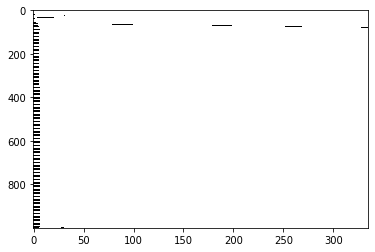

In [0]:
absf = np.abs(ff[0:round(len(ff)/2)])
absf = np.log(absf)
plane = GSS(absf)
plt.imshow(plane,cmap = 'Greys', interpolation='nearest', aspect = 'auto')

[lengths, indices] = LengthScaleCurve(plane)

hist_max = np.max(lengths)
print(np.histogram(lengths,hist_max.astype(int))[0])

The next step is to use a thresholding technique to classify a subset of minima as persistent. For this, many options exist. A favorable option in image processing however is Otsu's method. Otsu's method tries to find a 2-class classification that minimizes intra-class variance. (Code was modified from [3])

In [0]:
def otsu(lengths):
    hist_max = np.max(lengths); 
    histogram = np.histogram(lengths,hist_max.astype(int))[0]
    hist_normalized = histogram/np.sum(histogram) #normalize
    Q = hist_normalized.cumsum()
    
    bins = np.arange(hist_max)
    fn_min = np.inf
    thresh = -1

    for i in range(1,hist_max.astype(int)):
        p1, p2 = np.hsplit(hist_normalized, [i])
        q1, q2 = Q[i], Q[hist_max.astype(int)-1] - Q[i]
        if q1 < 1.e-6 or q2 < 1.e-6:
            continue
        b1, b2 = np.hsplit(bins,[i]) #weights

        #Means and variances
        m1 = np.sum(p1*b1)/q1
        m2 = np.sum(p2*b2)/q2
        v1 = np.sum((b1-m1)**2*p1)/q1
        v2 = np.sum((b2-m2)**2*p2)/q2

        #calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
    return thresh

Applying our implementation of Otsu's method to our minima lengths, we can define our boundaries.


In [0]:
thresh = Otsu(lengths)
bounds = indices[lengths >= thresh]
print(bounds) 
bounds = np.pi*bounds/len(ff)

[ 24.  33.  63. 995.]


From these boundaries, we can now define the empirical wavelet transform. We begin by defining the functions  EWT_beta, EWT_LP_Scaling, and EWT_LP_Wavelet which we will need for the construction of our filters.

In [0]:
def EWT_beta(x):
    bm = (x >= 0)*(x <= 1)*(x**4 * (35 - 84*x + 70*x**2 - 20*x**3))
    bm += (x > 1)
    return bm

def EWT_LP_Scaling(w1,aw,gamma,N):
    mbn = (1 - gamma)*w1 #beginning of transition
    pbn = (1 + gamma)*w1 #end of transition
    an = 1/(2*gamma*w1) #scaling in beta function

    yms = 1.0*(aw <= mbn) #if less than lower bound, equals 1
    yms += (aw > mbn)*(aw <= pbn)*np.cos(np.pi*EWT_beta(an*(aw - mbn))/2) #Transition area
    return yms

def EWT_LP_Wavelet(wn,wm,aw,gamma,N):
    if wn > np.pi:  #If greater than pi, subtract 2pi, otherwise dont
        a = 1;
    else:
        a = 0

    mbn = wn - gamma*abs(wn - a*2*np.pi) #beginning of first transition
    pbn = wn + gamma*abs(wn - a*2*np.pi) #end of first transition
    an = 1/(2*gamma*abs(wn - a*2*np.pi)) #scaling in first transition's beta function

    if wm > np.pi: #If greater than pi, subtract 2pi, otherwise dont
        a=1;
    else:
        a=0;
    
    mbm = wm - gamma*abs(wm - a*2*np.pi); #beginning of second transition
    pbm = wm + gamma*abs(wm - a*2*np.pi); #end of second transition
    am = 1/(2*gamma*abs(wm - a*2*np.pi));  #scaling in second transition's beta function
    
    ymw = 1.0*(aw >= pbn)*(aw<= mbm) #equals 1 between transition areas
    ymw += (aw > mbn)*(aw < pbn)*np.sin(np.pi*EWT_beta(an*(aw - mbn))/2) #1st transition area
    if wm < np.pi:
        ymw += (aw > mbm)*(aw < pbm)*np.cos(np.pi*EWT_beta(am*(aw - mbm))/2) #2nd transition area
    else:
        ymw += (aw > mbm)*(aw < pbm)*1.0
    return ymw


With these, we can define a function which constructs the empirical wavelet filter-bank. We first calculate gamma, which as a reminder can be chosen to guarantee a tight frame.

Then, we construct our filterbank from the set of detected boundaries in a form inspired by Littlewood-Paley wavelets

In [0]:
def EWT_LP_Filterbank(bounds,N):
    #Calculate Gamma
    gamma = 1;
    for i in range(0,len(bounds)-1):
        r = (bounds[i+1] - bounds[i])/(bounds[i+1]+bounds[i])
        if r < gamma:
            gamma = r
    aw = np.arange(0,2*np.pi,2*np.pi/N)
    aw[np.floor(N/2).astype(int):] -= 2*np.pi 
    aw = np.abs(aw)
    filterbank = np.zeros([N, len(bounds)+1])
    filterbank[:,0] = EWT_LP_Scaling(bounds[0],aw,gamma,N)
    for i in range(1,len(bounds)):
        filterbank[:,i] = EWT_LP_Wavelet(bounds[i-1],bounds[i], aw, gamma, N)
    filterbank[:,len(bounds)] = EWT_LP_Wavelet(bounds[len(bounds)-1],np.pi,aw,gamma,N)
    return filterbank

Using our function, we can get our empirical wavelet coefficients and plot them below. Note, we also calculate the sum of the energy to show that our filter bank indeed forms a tight frame.

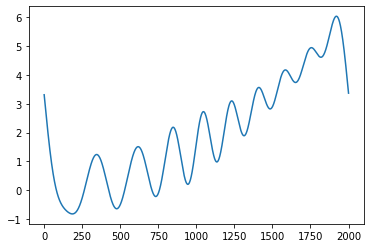

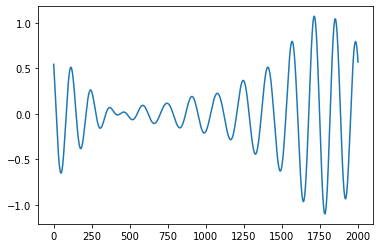

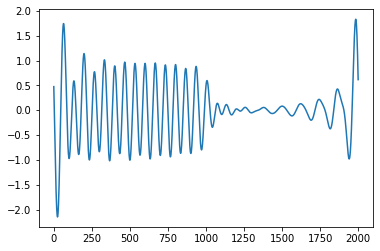

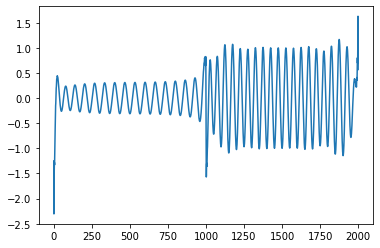

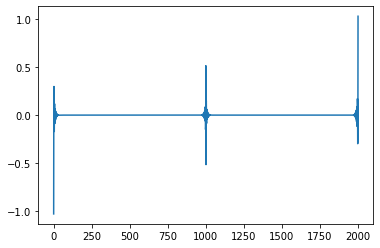

In [0]:
mfb = EWT_LP_Filterbank(bounds,len(ff))
[N, num_filters] = mfb.shape
ewt = np.zeros([N, num_filters])
energy = 0
for i in range(0,num_filters):
    ewt[:,i] = np.real(np.fft.ifft(mfb[:,i]*ff))
    plt.plot(ewt[:,i])
    plt.show()
    energy += mfb[:,i]**2

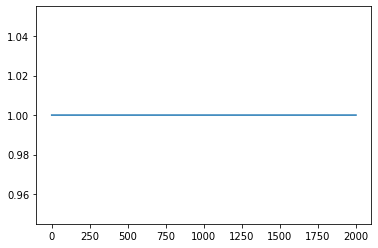

In [0]:
plt.plot(energy)
plt.show()

### Bibliography
[1] J.Gilles, "Empirical Wavelet Transform" in IEEE Trans. Signal Processing, Vol.61, No.16, 3999--4010, August 2013

[2] J.Gilles, K.Heal, "A parameterless scale-space approach to find meaningful modes in histograms - Application to image and spectrum segmentation". International Journal of Wavelets, Multiresolution and Information Processing, Vol.12, No.6, 1450044-1--1450044-17, December 2014

[3] https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html